<a href="https://colab.research.google.com/github/tsakailab/iip/blob/main/sandbox/pytorch_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pre setting

In [1]:
import matplotlib.pyplot as plt
import torch

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # setting GPU device
print(device)

# download data

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

!wget -nc https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -qu hymenoptera_data.zip -d ./

# ants = glob.glob('./hymenoptera_data/train/ants/*')
# bees = glob.glob('./hymenoptera_data/train/bees/*')
# f=lambda x: np.array(Image.open(x))
# ants = np.array(list(map(f,ants)))
# bees = np.array(list(map(f,bees)))
# data = np.concatenate((ants,bees),0)
# labels = np.concatenate((np.zeros(len(ants)),np.ones(len(bees))),0).astype('int64')

# ants_val = glob.glob('./hymenoptera_data/val/ants/*')
# bees_val = glob.glob('./hymenoptera_data/val/bees/*')
# f=lambda x: np.array(Image.open(x))
# ants_val = np.array(list(map(f,ants_val)))
# bees_val = np.array(list(map(f,bees_val)))
# data_val = np.concatenate((ants_val,bees_val),0)
# labels_val = np.concatenate((np.zeros(len(ants_val)),np.ones(len(bees_val))),0).astype('int64')
from glob import glob
print('ants:', str(len(glob('./hymenoptera_data/train/ants/*'))), 'images')
print('bees:', str(len(glob('./hymenoptera_data/train/bees/*'))), 'images')


--2021-12-03 07:04:56--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.226.62.61, 13.226.62.45, 13.226.62.19, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.226.62.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  10.5MB/s    in 4.3s    

2021-12-03 07:05:01 (10.5 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

ants: 124 images
bees: 121 images


# prepare data. making data loaders

In [112]:
# dataloader作り
# Data augmentation and normalization for training
# Just normalization for validation

batch_size = 32

from torchvision import transforms
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(224),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './hymenoptera_data/'
from torchvision import datasets
import os
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(dataset_sizes)

{'train': 244, 'val': 153}


# plot sample image
アリやハチの画像が表示されます。
苦手な方は実行を控えて下さい。

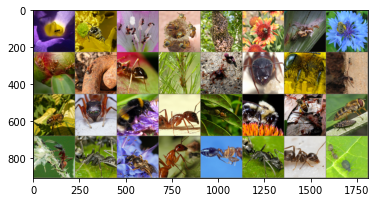

In [204]:
import numpy as np
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
import torchvision
out = torchvision.utils.make_grid(inputs)
# imshow(out, title=[class_names[x] for x in classes])
imshow(out)

# pytorchによるモデル作成

## prepare model

実際にモデルを組んでみましょう
下記mymodelクラスのself.feature_extractorへ入力されるものを書き換えて下さい。

最終的に出力される特徴マップのチャネル数は別途控えておいてください。


以下はサンプルです。

convolution layer:https://pytorch.org/docs/stable/nn.html#convolution-layers

sample: 2d convolution layer
```
nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True),
)
```

activation function:https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

sample: ReLU

```
nn.Sequential(
    nn.ReLU(),
)
```

pooling layer:https://pytorch.org/docs/stable/nn.html#pooling-layers

sample: 2d max pooling layer
```
nn.Sequential(
    nn.MaxPooling2d(),
)
```

これらを組み合わせる：
```
nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True),
    nn.ReLU(),
    nn.MaxPooling2d(),
)
```

In [105]:
from torch import nn
from torchvision import models

class my_model(nn.Module):
    def __init__(self, output_channel):
        super().__init__()
        # self.feature_extractor = models.vgg16_bn().features
        self.feature_extractor = nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),

            torch.nn.Conv2d(64, 128, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),

            torch.nn.Conv2d(128, 256, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),

            
            # ___ # ここを変更する
        )
        self.fc1 = nn.Linear(output_channel,2, bias=False)

    def forward(self,x):
        x = self.feature_extractor(x)
        x = x.mean([-2, -1])
        # x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        return x

## モデルをインスタンス化する

In [106]:
output_channel = 512 # 最終的に出力される特徴マップのチャネル数をここに入力してください。
model = my_model(output_channel).to(device)
print(model)

my_model(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): C

## モデルの規模を確認する

torchsummary
か
torchinfo
が利用できます。

初学者としてはtorchsummaryの方がより簡素に表示されるため、見やすいと思います。

torchinfoはbatch_sizeまで指定でき、かつ細かく見ることができるため便利です。

今回はtorchsummaryを利用します。

In [107]:
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

## setting optimizer

In [108]:
criterion = nn.CrossEntropyLoss() # 交差エントロピー損失を損失関数に設定

from torch import optim
# optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model.parameters(), lr=0.0001)
# optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

# from torch.optim import lr_scheduler
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


## training function

In [109]:
import time
import copy
 ## Define some function(training, printing result)
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_dict = {'train':[], 'val':[]}
    acc_dict = {'train':[], 'val':[]}
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            loss_dict[phase].append(epoch_loss)
            acc_dict[phase].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_dict, acc_dict


## start training!

In [110]:
model_ft, loss_dict, acc_dict = train_model(model, criterion, optimizer_ft, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5995 Acc: 0.6516
val Loss: 0.7724 Acc: 0.4575

Epoch 1/24
----------
train Loss: 0.6559 Acc: 0.6844
val Loss: 0.9238 Acc: 0.4575

Epoch 2/24
----------
train Loss: 0.4512 Acc: 0.8033
val Loss: 0.6991 Acc: 0.5556

Epoch 3/24
----------
train Loss: 0.4698 Acc: 0.7951
val Loss: 0.5384 Acc: 0.7320

Epoch 4/24
----------
train Loss: 0.4081 Acc: 0.8238
val Loss: 0.7532 Acc: 0.6536

Epoch 5/24
----------
train Loss: 0.4136 Acc: 0.8156
val Loss: 0.6922 Acc: 0.7124

Epoch 6/24
----------
train Loss: 0.3502 Acc: 0.8484
val Loss: 0.7150 Acc: 0.7255

Epoch 7/24
----------
train Loss: 0.3309 Acc: 0.8566
val Loss: 0.6371 Acc: 0.7124

Epoch 8/24
----------
train Loss: 0.3953 Acc: 0.8320
val Loss: 0.5428 Acc: 0.7647

Epoch 9/24
----------
train Loss: 0.2956 Acc: 0.8893
val Loss: 0.5269 Acc: 0.7647

Epoch 10/24
----------
train Loss: 0.2912 Acc: 0.8811
val Loss: 0.6307 Acc: 0.6928

Epoch 11/24
----------
train Loss: 0.2421 Acc: 0.9098
val Loss: 0.6524 Acc: 0.6863

Ep

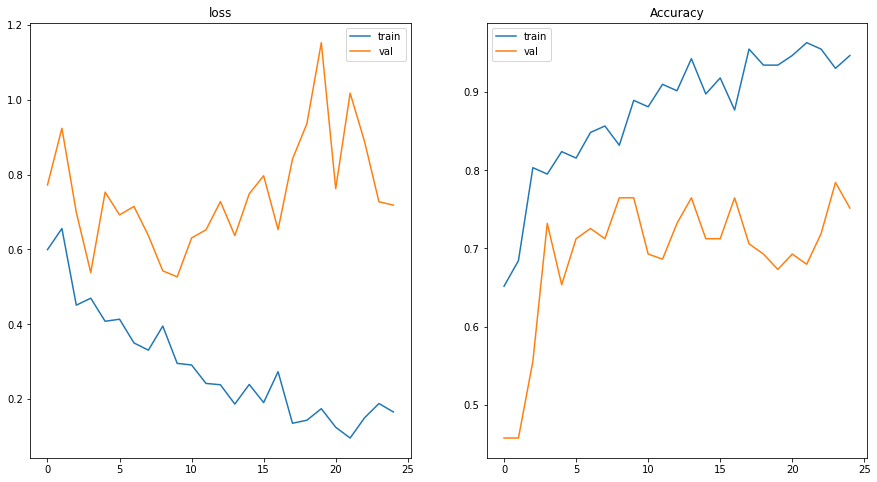

In [111]:
def plotting_history(loss_dict, acc_dict):
    epoch = len(loss_dict['train'])
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
    axes[0].plot(range(epoch), loss_dict['train'], label='train')
    axes[0].plot(range(epoch), loss_dict['val'], label='val')
    axes[0].set_title("loss")
    axes[0].legend()

    axes[1].plot(range(epoch), acc_dict['train'], label='train')
    axes[1].plot(range(epoch), acc_dict['val'], label='val')
    axes[1].set_title("Accuracy")
    axes[1].legend()

plotting_history(loss_dict, acc_dict)

## 入力画像とモデルによる推論を出力する

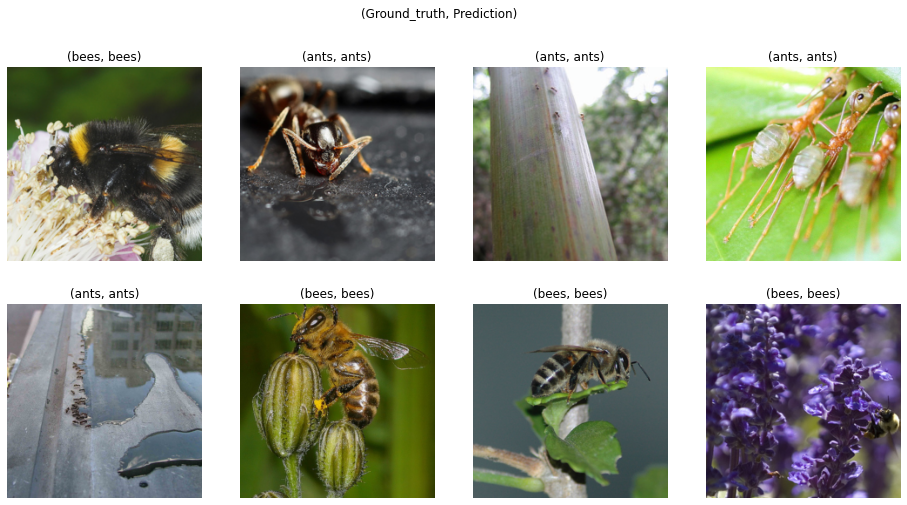

In [201]:
def visualize_model(model, num_images=6, font_size=12):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(num_images/(num_images//4)*4, (num_images//4)*4))
    plt.suptitle('(Ground_truth, Prediction)')

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                plt.subplot(num_images//4, num_images//(num_images//4), images_so_far)
                plt.axis('off')
                inp = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                plt.imshow(inp)
                plt.title('({}, {})'.format(class_names[labels[j]], class_names[preds[j]]),fontsize=font_size)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model_ft, num_images=8)
plt.show()

# 事前学習済みモデルの利用～転移学習～


ImageNetで事前学習済みのVGG16を利用します。
まずは事前学習済みVGG16を入手します。

In [ ]:
from torchvision import models
vgg = models.vgg16(pretrained=True).to(device)
print(vgg)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## 事前学習済みモデルの規模を確認する


VGG16の学習可能パラメータ数を確認してみます。
全結合層のパラメータが非常に多く、学習可能パラメータ数の大部分を占めている事が分かります。

In [ ]:
summary(vgg, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## 転移学習のため、VGGの特徴抽出部だけを引き抜く


転移学習に必要なものは事前学習済みネットワークの畳み込み特徴抽出部です。
該当する部分のみを引き抜きます。

In [ ]:
feature_extractor = ___ # ここを変更する。

In [ ]:
#@title 答え
feature_extractor = vgg.features

In [ ]:
summary(feature_extractor, (3, 224, 224))

## 引き抜く特徴抽出部の長さを調節する。


引き抜かれた特徴抽出部はnn.Sequentialによるlist構造になっています。


In [ ]:
feature_extractor = vgg.features # ここを改変する。

## 自作モデルの特徴抽出部をVGGの特徴抽出部に置き換える

In [ ]:
from torch import nn

class my_model(nn.Module):
    def __init__(self, output_channel):
        super().__init__()

        self.feature_extractor = vgg.features # ここを変更する
        self.fc1 = nn.Linear(output_channel,2)

    def forward(self,x):
        x = self.feature_extractor(x)
        x = x.mean([-2, -1])
        x = self.fc1(x)
        return x

In [ ]:
output_channel = 512 # 最終的に出力される特徴マップのチャネル数をここに入力してください。
model = my_model(output_channel).to(device)

In [ ]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## 転移学習モデルを自前のデータセットに対して学習する(fine tuning)

In [ ]:
criterion = nn.CrossEntropyLoss() # 交差エントロピー損失を損失関数に設定

from torch import optim
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
model_ft, loss_dict, acc_dict = train_model(model, criterion, optimizer_ft, num_epochs=25)

Epoch 0/14
----------
train Loss: 0.3583 Acc: 0.8443
val Loss: 0.3279 Acc: 0.8497

Epoch 1/14
----------
train Loss: 0.2803 Acc: 0.8770
val Loss: 0.2572 Acc: 0.9216

Epoch 2/14
----------
train Loss: 0.2238 Acc: 0.9098
val Loss: 0.2382 Acc: 0.9216

Epoch 3/14
----------
train Loss: 0.1005 Acc: 0.9590
val Loss: 0.1824 Acc: 0.9281

Epoch 4/14
----------
train Loss: 0.3016 Acc: 0.8852
val Loss: 0.6568 Acc: 0.7386

Epoch 5/14
----------
train Loss: 0.3242 Acc: 0.8566
val Loss: 0.2309 Acc: 0.9085

Epoch 6/14
----------
train Loss: 0.1791 Acc: 0.9426
val Loss: 0.2614 Acc: 0.8954

Epoch 7/14
----------
train Loss: 0.2693 Acc: 0.8770
val Loss: 0.3682 Acc: 0.8562

Epoch 8/14
----------
train Loss: 0.0934 Acc: 0.9713
val Loss: 0.5225 Acc: 0.8889

Epoch 9/14
----------
train Loss: 0.1961 Acc: 0.9344
val Loss: 0.2405 Acc: 0.9085

Epoch 10/14
----------
train Loss: 0.2369 Acc: 0.9016
val Loss: 0.2356 Acc: 0.9150

Epoch 11/14
----------
train Loss: 0.0660 Acc: 0.9877
val Loss: 0.3975 Acc: 0.9085

Ep

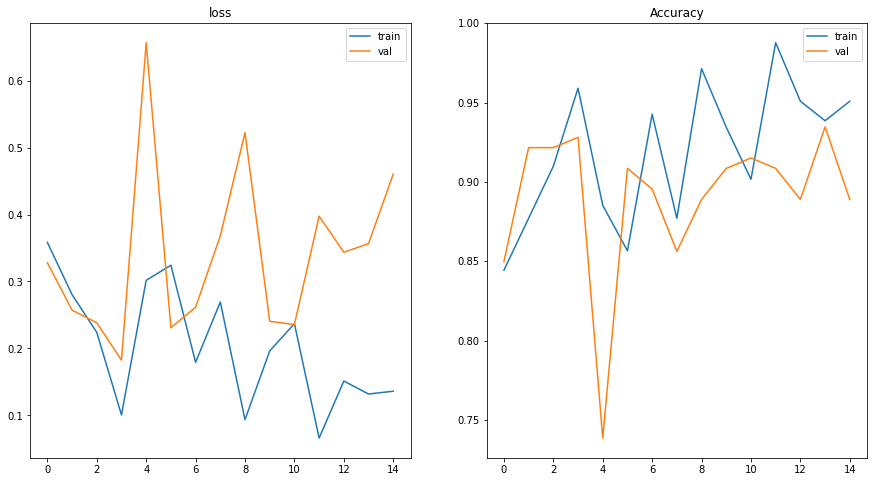

In [ ]:
plotting_history(loss_dict, acc_dict)

## 入力画像とモデルによる推論を出力する

In [ ]:
visualize_model(model_ft)

plt.ioff()
plt.show()

# Class Activation Map


camを作ってみましょう．CAMが紹介されてる論文のリンクは[こちら](http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf)

CAMは以下の式で与えられます．

## $ M_c(x, y) = \sum_{k}{w^c_k f_k(x,y)}$

ここで$M_c(x, y)$はc番目のクラスに対するCAMにおける，座標$(x,y)$の画素値．$w^c$は最終層となる全結合層の重みにおいて，クラスcに対応する出力のもの．$f_k(x,y)$は最後の特徴マップにおいて，座標$(x,y)$の画素値．kは特徴マップのチャネル数に対応する添え字．$w^c_k$の$k$も同様．

Text(0.5, 1.0, 'cam:bees')

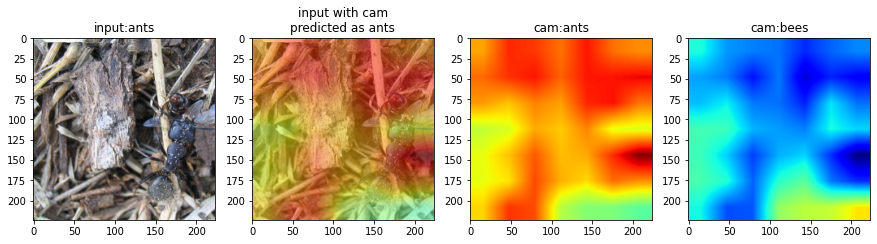

In [ ]:
# set random input image
import random
from PIL import Image
target_num = 0
target = ['ants','bees'][target_num]
img = Image.open('./hymenoptera_data/val/{}/'.format(target) + random.choice(os.listdir('./hymenoptera_data/val/{}/'.format(target))))
img = data_transforms['val'](img)

# prepare the input image for plot
inp = img
inp = inp.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean
inp = np.clip(inp, 0, 1)

# extract layers
model_features = model_ft.feature_extractor
model_dense = model_ft.fc1

# make layer used to make cam
cam_extractor = torch.nn.Conv2d(model_dense.weight.shape[1], model_dense.weight.shape[0], 1, padding=0, bias=False)
cam_extractor.weight = torch.nn.Parameter(model_dense.weight.unsqueeze(-1).unsqueeze(-1))

# calc feature maps
features = model_features(img.unsqueeze(0).to(device))

# predict
pooled = features.mean([-2,-1])
pred = model_dense(pooled)

# calc cam
cam = cam_extractor(features)
cam = cam.squeeze()

# normalize cam
cam_min = torch.min(cam)
cam_max = torch.max(cam - cam_min)
cam = (cam - cam_min)/cam_max

# resize cam
resizing_function = transforms.Compose([
        transforms.Resize(224),
    ])
cam = resizing_function(cam)

def toHeatmap(x):
    x = (x*255).reshape(-1)
    cm = plt.get_cmap('jet')
    x = np.array([cm(int(np.round(xi)))[:3] for xi in x]) # ここの処理が重い．
    width = img.shape[-1]
    return x.reshape(width,width,3)

# make cam heatmap
cam = [toHeatmap(cam[0].detach().cpu()),
       toHeatmap(cam[1].detach().cpu())]

# set alpha value
alpha = 0.5

# mask input image by cam
cam_image = inp*alpha + cam[target_num]*(1-alpha)

# plot
fig = plt.figure(figsize = (15,8))
plt.subplot(1,4,1)
plt.imshow(inp)
plt.title('input:{}'.format(['ants','bees'][target_num]))
plt.subplot(1,4,2)
plt.title('input with cam\npredicted as {}'.format(['ants','bees'][torch.max(pred, 1)[1].item()]))
plt.imshow(cam_image)
plt.subplot(1,4,3)
plt.imshow(cam[0])
plt.title('cam:{}'.format(['ants','bees'][0]))
plt.subplot(1,4,4)
plt.imshow(cam[1])
plt.title('cam:{}'.format(['ants','bees'][1]))

grad-camを作ってみましょう．grad-camの論文は[こちらから](https://openaccess.thecvf.com/content_iccv_2017/html/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.html)

grad-camは以下の式で与えられます．CAMの方の式と表記がずれているのは論文記載のものと合わせているからです．

## $L^c_{Grad-CAM} = ReLU(\sum_{k}{\alpha^c_k A^k})$

ここで$L^c_{Grad-CAM}$はクラス$c$に対応するgrad-cam．$\alpha^c_k$は$c$番目のクラスに対応する出力から逆伝搬した際，各特徴マップの画素ごとに計算された重みをGAPしたもの．$A^k$は最後の特徴マップ．

上の説明だけでは$\alpha$とはなんぞやとなるかと思いますので，ここに$\alpha^c_k$を導出する式を載せておきます．

# $\alpha^c_k = \frac{1}{Z}\sum_{i}\sum_{j}\frac{\partial y^c}{\partial A^k_{ij}}$

ここで$y^c$はクラス$c$に対応する出力．$ij$は画素の$(x,y)$に対応する添え字です．Zに関する記述はありませんでした．推測ですが，Zは特徴マップの$x\times y$になると思います．

Text(0.5, 1.0, 'grad cam:ants')

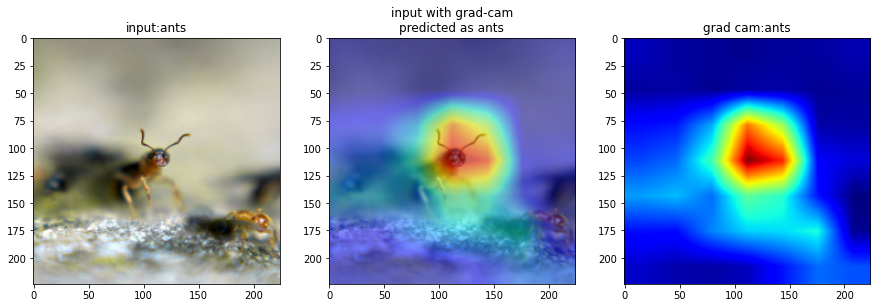

In [ ]:
# set random input image
import random
target_num = 0
target = ['ants','bees'][target_num]
img = Image.open('./hymenoptera_data/val/{}/'.format(target) + random.choice(os.listdir('./hymenoptera_data/val/{}/'.format(target))))
img = data_transforms['val'](img)

# prepare the input image for plot
inp = img
inp = inp.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean
inp = np.clip(inp, 0, 1)

# extract layers
model_features = model_ft.feature_extractor
model_dense = model_ft.fc1

# calc feature maps
features = model_features(img.unsqueeze(0).to(device))
features = features.clone().detach().requires_grad_(True)

# predict and backward to calcurate grad
pooled = features.mean([-2,-1])
pred = model_dense(pooled)
pred[0, target_num].backward()

# grad -> 1d tensor
feature_vec = features.grad.view(features.shape[1], features.shape[-2], features.shape[-1])

# mean grad and GAP it
alpha = torch.mean(feature_vec, axis=1)
features = features.squeeze(0)

# make grad-cam by using pooled grad
grad_cam = torch.nn.functional.relu(torch.sum(features*alpha.unsqueeze(-1),0))

# normalize cam
grad_cam_min = torch.min(grad_cam)
grad_cam_max = torch.max(grad_cam - grad_cam_min)
grad_cam = (grad_cam - grad_cam_min)/grad_cam_max

# resize cam
resizing_function = transforms.Compose([
        transforms.Resize(224),
    ])
grad_cam = resizing_function(grad_cam.unsqueeze(0)).squeeze()

def toHeatmap(x):
    x = (x*255).reshape(-1)
    cm = plt.get_cmap('jet')
    x = np.array([cm(int(np.round(xi)))[:3] for xi in x]) # ここの処理が重い．
    width = img.shape[-1]
    return x.reshape(width,width,3)

# make cam heatmap
grad_cam = toHeatmap(grad_cam.detach().cpu())

# set alpha value
alpha = 0.5

# mask input image by cam
grad_cam_image = inp*alpha + grad_cam*(1-alpha)

# plot
fig = plt.figure(figsize = (15,8))
plt.subplot(1,3,1)
plt.imshow(inp)
plt.title('input:{}'.format(['ants','bees'][target_num]))
plt.subplot(1,3,2)
plt.title('input with grad-cam\npredicted as {}'.format(['ants','bees'][torch.max(pred, 1)[1].item()]))
plt.imshow(grad_cam_image)
plt.subplot(1,3,3)
plt.imshow(grad_cam)
plt.title('grad cam:{}'.format(['ants','bees'][target_num]))

- RISE: Randomized Input Sampling for Explanation of Black-box Models
https://arxiv.org/abs/1806.07421
- "Why Should I Trust You?": Explaining the Predictions of Any Classifier
https://dl.acm.org/doi/abs/10.1145/2939672.2939778, https://arxiv.org/pdf/1602.04938.pdf
- Group-CAM: Group Score-Weighted Visual Explanations for Deep Convolutional Networks
https://arxiv.org/abs/2103.13859

# 一旦ここまで改変済み

In [ ]:
# make model
model = models.resnet18(pretrained=True)
print(model)
#model = model = models.vgg16(pretrained=True)

num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
from torch import nn
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
from torch import optim
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs

from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

以下はtutorialにない内容．

できたら便利だという事を武田の独断と偏見で追加しています．

In [ ]:
# tqdmを使ってみる
# train_model_tqdmという関数を作っておきました．引数は同じなので，使ってみて下さい．


In [ ]:
# batch_sizeを変えてみる
# 先に宣言したimshowあたりで見てみてください．

#
# batch_sizeを変えたdataloaders作成
#

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
print(classes)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
#@title ##難しいので折り畳み
# MRIグループ向け．
# 既に全データがnumpyで保存されているとき，どのようにdataloadersを作る？
# ヒント：クラスを宣言することが必要です．
# [答えはここに]内に武田が書いたmydatasetsというクラスがあります．
# 殆ど最小限の構造になっているはずなので，見てみてほしい．

# 全部盛りnumpyファイルの作成
data = data # 画像データ
labels = labels # ラベルデータ(アリ:0,ハチ:1)

#
# datasetクラスの宣言
#

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_train = mydatasets(data, labels, data_transforms['train'])
train_loaders = torch.utils.data.DataLoader(data_train, batch_size=2, shuffle=True)

# Get a batch of training data
inputs, classes = next(iter(train_loaders))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
#@title ##答えはここに
# こんな感じのクラスを作成すれば達成できます．
class mydatasets(torch.utils.data.Dataset):
    def __init__(self, data, labels, transforms=None):
        self.data = data # データはdataという変数に格納されます．
        self.label = labels # ラベルはlabelという変数に．
        self.datanum = len(self.data) # コレを設定すると，総データ数をdataloaderが管理してくれます．
        self.transforms = transforms # data augmentation(データ拡張)の設定を保存．
        
    def __len__(self):
        return self.datanum
    
    def __getitem__(self, idx):
        out_data = Image.fromarray(self.data[idx]) # データ読み取り
        out_label = self.label[idx]
        if self.transforms:
            out_data = self.transforms(out_data)
        return out_data, out_label

In [ ]:
# modelをプリントしてみる
# modelはどのような構造となっているのかを確認してみて下さい．


In [ ]:
# かなり長い文字列が表示されたと思います．
# では，VGG16のものを表示してみてください．


# 多少は短いものが表示されると思います．

In [ ]:
#@title ##答え
model = models.vgg16(pretrained=True)
print(model)

In [ ]:
# VGG16の特徴抽出部より特徴抽出部を抜き出してください．
# featuresとある部分がそれに対応します．


In [ ]:
#@title ##答え
feature_extraction = model.features
print(feature_extraction)

In [ ]:
# 抜きだした特徴抽出部から一部をさらに取り出してください．
# 何処でもいいですが，悩むのであれば最後から2段目のMaxPooling層までを抜き出してみて下さい．

# こうして転移学習する層数を変えることができます．
# 層数が少なければどのような特徴が抽出されるか，逆に層が厚い場合はどうなのか，考えてみて下さい．
# 受容野とかそういう話です．
# 分からなければ松尾とかが詳しいはずです．聞いてみて下さい．

In [ ]:
#@title ##答え
feature_extraction = model.features
layers = feature_extraction[:23]
print(layers)

In [ ]:
# 抜き出したモデルの重みをプリントしてみて下さい．

# モデルの重みを書き換えることができるようになります．

In [ ]:
#@title ##答え
feature_extraction = model.features
layers = feature_extraction[:23]

print(feature_extraction[0].weight)

In [ ]:
# モデルの重みを書き換えてみて下さい．
# test_layerを用意しました．この層の重みを何か別のものに書き換えてください．

test_layer = torch.nn.Conv2d(3,32,3)

# 1×1フィルタを意図したフィルタにイニシャライズしたり，2dconv層で画像処理的フィルタを仕込むことができるようになります．

In [ ]:
#@title 答え
test_layer = torch.nn.Conv2d(3,32,3)
test_layer.weight = torch.nn.Parameter(torch.zeros(32,3,3,3))
print(test_layer.weight)

In [ ]:
# 御託はそろそろとして，モデルを自分で組んでみましょう．
# ひな型を武田が用意しました．
# 1層の畳み込み層のみで構成されるネットワークを作ってみましょう．
# 入力は(224,224,3)の3チャネル画像を想定します．
# つまりinput_channelは3です．公式のAPIを見に行ったりして書いてみて下さい．
# 公式API:https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

# 記入する際，out_channelを決定する必要があると思います．
class my_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.out_channel = ___
        self.conv = ___ # ここに記入
        self.fc1 = nn.Linear(self.out_channel,2)
        
    def forward(self,x):
        x = self.conv(x)
        
        x = x.view(x.shape[0],2224*224*self.out_channel)
        x = self.fc1(x)   #上の部分をしっかり記入できていれば動くようになっています．

        return 

In [ ]:
#@title ##答え
class my_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.out_channel = 64
        self.conv = torch.nn.Conv2d(3,self.out_channel,3,bias=True,padding = 1)
        self.fc1 = nn.Linear(outself.out_channel_channel*224*224,2)
        
    def forward(self,x):
        x = self.conv(x)
        x = x.view(x.shape[0],224*224*self.out_channel)
        x = self.fc1(x)

        return x

In [ ]:
# 作成したモデルを学習させてみましょう！
# 多分ですが，わけわからん事になります．
# (最適化関数をAdamにすることで少しはマシになります．やってみてもよろし)
model = my_model().to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

In [ ]:
# 活性化関数を入れてみる
# たまに聞く活性化関数なるものを導入してみましょう．
# 特徴抽出を行うレイヤーの後ろに置きます．
# 今回はReLUを使ってみて下さい．

class my_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.out_channel = ___
        self.conv = torch.nn.Conv2d(3,self.out_channel,3,bias=True,padding = 1) # ここに記入
        self.activate = ____ # ReLUを導入してみましょう．
        self.fc1 = nn.Linear(224*224*self.out_channel,2)
        
    def forward(self,x):
        x = self.conv(x)
        x = self.activate(x)
        
        x = x.view(x.shape[0],224*224*self.out_channel)
        x = self.fc1(x)   #上の部分をしっかり記入できていれば動くようになっています．

        return x

In [ ]:
#@title ##答え
class my_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.out_channel = 64
        self.conv = torch.nn.Conv2d(3,self.out_channel,3,bias=True,padding = 1) # ここに記入
        self.activate = torch.nn.ReLU() # ReLUを導入してみましょう．
        self.fc1 = nn.Linear(self.out_channel*224*224,2)
        
    def forward(self,x):
        x = self.conv(x)
        x = self.activate(x)
        
        x = x.view(x.shape[0],224*224*self.out_channel)
        x = self.fc1(x)
        return x

In [ ]:
#@title ##学習用セル
model = my_model().to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

In [ ]:
# Poolingもしてみましょう．
# VGGにも含まれるMaxPooling層を導入します．
# 特徴抽出部のすぐ後ろに入れてみましょう．
# 今回はforwardも自力で書き換えてみて下さい．
# チャネル数を変えてみてもいいかもしれません．

class my_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.out_channel = ___
        self.conv = torch.nn.Conv2d(3,self.out_channel,3,bias=True,padding = 1) # ここに記入
        self.activate = torch.nn.ReLU()
        self.fc1 = nn.Linear(self.out_channel*112*112,2)
        self.pooling = ___ #ここに記入してみて下さい．
        
    def forward(self,x):
        x = self.conv(x)
        x = self.activate(x)
        
        x = x.view(x.shape[0],112*112*self.out_channel)
        x = self.fc1(x)   #上の部分をしっかり記入できていれば動くようになっています．

        return x

In [ ]:
#@title 答え
class my_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.out_channel = 64
        self.conv = torch.nn.Conv2d(3,self.out_channel,3,bias=True,padding = 1) # ここに記入
        self.activate = torch.nn.ReLU()
        self.fc1 = nn.Linear(self.out_channel*112*112,2)
        self.pooling = torch.nn.MaxPool2d(2) #ここに記入してみて下さい．
        
    def forward(self,x):
        x = self.conv(x)
        x = self.activate(x)
        x = self.pooling(x)
        
        x = x.view(x.shape[0],112*112*self.out_channel)
        x = self.fc1(x)   #上の部分をしっかり記入できていれば動くようになっています．

        return x

In [ ]:
#@title ##学習用セル(学習が進まなかったのでここだけAdam)
model = my_model().to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

In [ ]:
# では，特徴抽出部を増やしてみましょう．
# 一気に2層ほど増やしてみることにします．
# 今回はヒント無しです．答えは用意しておきますが，実際に書いてみて下さい．
class my_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.out_channel = ___
        self.conv = torch.nn.Conv2d(3,___,3,bias=True,padding = 1)
        self.activate = torch.nn.ReLU()
        self.fc1 = nn.Linear(self.out_channel,2)
        self.pooling = torch.nn.MaxPool2d(2)
        
    def forward(self,x):
        x = self.conv(x)
        x = self.activate(x)
        x = self.pooling(x)
        
        x = x.view(x.shape[0],28*28*self.out_channel)
        x = self.fc1(x)

        return x

In [ ]:
#@title ##答え
class my_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.out_channel = 64
        self.conv1 = torch.nn.Conv2d(3,self.out_channel,3,bias=True,padding = 1)
        self.activate = torch.nn.ReLU()
        self.pooling = torch.nn.MaxPool2d(2)

        self.conv2 = torch.nn.Conv2d(self.out_channel,self.out_channel*2,3,bias=True,padding = 1)
        self.conv3 = torch.nn.Conv2d(self.out_channel*2,self.out_channel,3,bias=True,padding = 1)
        
        self.fc1 = nn.Linear(self.out_channel*28*28,2)
    def forward(self,x):
        x = self.conv1(x)
        x = self.activate(x)
        x = self.pooling(x)
        x = self.conv2(x)
        x = self.activate(x)
        x = self.pooling(x)
        x = self.conv3(x)
        x = self.activate(x)
        x = self.pooling(x)
        x = x.view(x.shape[0],28*28*self.out_channel)
        x = self.fc1(x)

        return x

In [ ]:
#@title ##学習用セル
model = my_model().to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

In [ ]:
# 少しはマシになったかもしれません．
# そろそろネットワークを作る事にも慣れてきたことでしょう．
# それでは，特徴抽出部を転移学習してみましょう．
# 特徴抽出部だけを抜き出してきた時を思い出してみて下さい．

class my_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = ___ # ここに記入
        self.activate = torch.nn.ReLU()
        self.avgpool = models.vgg16().avgpool
        self.fc1 = nn.Linear(512*7*7,2)
        
    def forward(self,x):

        x = self.avgpool(x)
        x = x.view(x.shape[0],512*7*7)
        x = self.fc1(x)

        return x

In [ ]:
#@title 答え
# 答えではVGG16を転移しています．
class my_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = models.vgg16(pretrained=True).features
        self.activate = torch.nn.ReLU()
        self.avgpool = models.vgg16().avgpool
        self.fc1 = nn.Linear(512*7*7,2)
        
    def forward(self,x):
        x = self.vgg(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0],512*7*7)
        x = self.fc1(x)

        return x

In [ ]:
#@title ##学習用セル
model = my_model().to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

In [ ]:
# 一応性能が出たと思います．
# 転移学習の力を思い知って頂ければ幸い．
# 転移学習しましたが，実際にはもうひと手間加えたい事があります．
# それは学習不可にする事です．
# 何故そうするかはパラメータ数が多すぎる事とかいろいろあるわけですが，まあ詳しくは割愛．と言うわけで学習不可，つまりfreezeしましょう．
# どうすればよいかは調べれば出てくるので，実践してみて下さい．
class my_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = models.vgg16(pretrained=True).features
        self.activate = torch.nn.ReLU()
        self.avgpool = models.vgg16().avgpool
        self.fc1 = nn.Linear(512*7*7,2)
        
    def forward(self,x):
        x = self.vgg(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0],512*7*7)
        x = self.fc1(x)

        return x

In [ ]:
#@title 答え
class my_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = models.vgg16(pretrained=True).features
        for layer in self.vgg:
            for param in layer.parameters():
                param.requires_grad = False
        self.activate = torch.nn.ReLU()
        self.avgpool = models.vgg16().avgpool
        self.fc1 = nn.Linear(512*7*7,2)
        
    def forward(self,x):
        x = self.vgg(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0],512*7*7)
        x = self.fc1(x)

        return x


In [ ]:
#@title ##学習用セル
model = my_model().to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

In [ ]:
# できましたか？
# 実際freezeできているか確認することはなかなか難しいと思います．
# そんなところで，便利なライブラリを紹介します．
# torchsummary君です．百聞は何とやらと言うわけで使ってみて下さい．便利さが分かります．(pip推奨．condaでインストールしようとすると変な事になります)
!pip install torchsummary
from torchsummary import summary
summary(model_ft,(3,224,224))
# ちなみにこのtorchsummary君ですが，0番目のGPUにモデルが載っている事を前提にできているみたいです．
# 複数GPUや，CPUを使う場合は利用できないのでご注意を．
# ここでtrainable parameterに振られている方はfreezeできていないのでやり直しです．

転移学習を実装する事に関してはマスターしたも同然です．

後は自分で学んでいけるでしょう(ここまでちゃんとやった人はそもそも自力で調べられる人だと思いますが)

ここから先は発展的内容になります．

武田が知っていた方が面白いのではと思った事を書き連ねているだけです．

もういいやという人はブラウザバック推奨．

In [ ]:
# さて，散々識別問題を解かせてきました．しかし実際にモデルは何処を見ているのでしょうか．
# その基準を知ろうという試みとして，CAM(class activation map)があります．
# 簡潔に言えば，モデルがどこを見て診断したか可視化したデータです．
# これは酒井研の研究では細胞診，MRIで利用されていますね．
# 詳しくはここでは触れません．調べてみてね．本項ではその実装について触れます．
# 作り方は次セルに任せるとして，このセルではモデルの出力を増やしてみましょう．

# モデルはさっきまで使っていたものとします．
# このモデルのうち，特徴抽出部から出て来たものをついでに出力してみましょう．
# どうすれば出力できるでしょうか？
class my_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = models.vgg16(pretrained=True).features
        self.activate = torch.nn.ReLU()
        self.avgpool = models.vgg16().avgpool
        self.fc1 = nn.Linear(512*7*7,2)
        
    def forward(self,x):
        x = self.vgg(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0],512*7*7)
        x = self.fc1(x)

        return x

In [ ]:
#@title 答え
class my_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = models.vgg16(pretrained=True).features
        self.activate = torch.nn.ReLU()
        self.avgpool = models.vgg16().avgpool
        self.fc1 = nn.Linear(512*7*7,2)
        
    def forward(self,x):
        x = self.vgg(x)
        feature_map = x.clone()
        x = self.avgpool(x)
        x = x.view(x.shape[0],512*7*7)
        x = self.fc1(x)

        return x, feature_map

実際に学習してみましょう．

本来はちょいと学習用関数も変更する必要がありますが，今回は学習用セルに含めておきました．
(0番目の出力が推論であることを想定しています．)

In [ ]:
#@title 学習用セル
def train_model_tqdm(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss,val_loss,train_acc,val_acc = 0,0,0,0
    with tqdm(range(num_epochs)) as bar:
        for epoch in bar:
            bar.set_description('Epoch {}/{}'.format(epoch, num_epochs - 1))
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)[0]
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                #print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                #    phase, epoch_loss, epoch_acc))

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase=='train':
                    train_loss = epoch_loss
                    train_acc = epoch_acc
                else:
                    val_loss = epoch_loss
                    val_acc = epoch_acc
            bar.set_postfix(OrderedDict(train_loss='{:.4f}'.format(train_loss), 
                                        train_accuracy = '{:.4f}'.format(train_acc),
                                        val_loss='{:.4f}'.format(val_loss), 
                                        val_accuracy = '{:.4f}'.format(val_acc)))
            print()
    time_elapsed = time.time() - since
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
#@title ##学習用セル
model = my_model().to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model_tqdm(model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

In [ ]:
# 学習が終わりましたね．
# 実際に算出される特徴マップを見てみましょうか．
img = Image.open('./hymenoptera_data/val/ants/Ant-1818.jpg')
img = data_transforms['val'](img)
imshow(img)
feature_map = model_ft(img.unsqueeze(0).to(device))[1]
fig = plt.figure(figsize=(15,15))
for x in range(1,6):
    plt.subplot(1,5,x)
    plt.imshow(feature_map.cpu().detach()[0][x], cmap='gray')

# まあ，ようわからんわけです．
# これは特徴抽出部の層を厚く取ったため，挟まれるPoolingでfeature mapのサイズが小さくなってしまっている事に起因しています．
# 一応この特徴マップでもどこから特徴を取得しているかわかりますが，それでも分かりづらいわけです．

In [ ]:
# ではCAMに移ります．
# CAMはGAP(Global average Pooling)層の入力として現れます．
# これを導入すると殆どFCN(Fully Convolutional Network)となるわけですが，学術的話は一切やりません．調べて．
# GAPはx.mean([2,3])で実装できます．楽ですね．
# CAMは各クラスの数だけである必要があります．
# 従って，512channelまで増えた特徴マップを2チャネルに落とす必要があるわけで．
# これは何層かConv2dを挟んで対応します．
# まあなんやかんや言ってますが，私の説明で分かるとも思えないので，実際にやってみましょう．難しいと思いますので，答えを見たりしてやってみて下さい．


In [ ]:
#@title 答え
class my_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = models.vgg16(pretrained=True).features
        for layer in self.vgg:
            for param in layer.parameters():
                param.requires_grad = False
        self.activate = torch.nn.ReLU()
        self.avgpool = models.vgg16().avgpool
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(512,128,3,padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,32,3,padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32,2,2,padding=1),
            torch.nn.ReLU(),
        )
        
    def forward(self,x):
        x = self.vgg(x)
        x = self.conv(x)
        cam = x.clone()
        x = x.mean([2,3])
        
        return x, cam

In [ ]:
#@title 学習用セル
def train_model_tqdm(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss,val_loss,train_acc,val_acc = 0,0,0,0
    with tqdm(range(num_epochs)) as bar:
        for epoch in bar:
            bar.set_description('Epoch {}/{}'.format(epoch, num_epochs - 1))
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)[0]
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                #print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                #    phase, epoch_loss, epoch_acc))

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase=='train':
                    train_loss = epoch_loss
                    train_acc = epoch_acc
                else:
                    val_loss = epoch_loss
                    val_acc = epoch_acc
            bar.set_postfix(OrderedDict(train_loss='{:.4f}'.format(train_loss), 
                                        train_accuracy = '{:.4f}'.format(train_acc),
                                        val_loss='{:.4f}'.format(val_loss), 
                                        val_accuracy = '{:.4f}'.format(val_acc)))
            print()
    time_elapsed = time.time() - since
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
#@title ##学習用セル
model = my_model().to(device)
summary(model,(3,224,224))
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model_tqdm(model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

In [ ]:
# CAMを出力してみましょう．
# 実行するたび別のものが表示されるので，いろいろと試してみて下さい．
# ちなみに推論されたクラスはCAMの上にある文字が赤くなります．
import random
target = ['ants','bees'][1]
img = Image.open('./hymenoptera_data/val/{}/'.format(target) + random.choice(os.listdir('./hymenoptera_data/val/{}/'.format(target))))
img = data_transforms['val'](img)
imshow(img)
outputs, cam = model_ft(img.unsqueeze(0).to(device))
_, preds = torch.max(outputs, 1)
fig = plt.figure(figsize=(7,7))
for x in range(2):
    plt.subplot(1,2,x+1)
    plt.imshow(cam.cpu().detach()[0][x], cmap='gray', vmin=cam.min(),vmax=cam.max())
    plt.title(class_names[x],color="red" if preds == x else 'black')
